# Attempt to extract bedloads from seismic and river discharge time series

Originally by Brad Lipovsky (bpl7@uw.edu), modified by Marine Denolle (mdenolle@uw.edu) and Claude Sonnet.
Modified 
This notebook :
- pulls a metadata of pairs of seismic stations and river gages
- pulls the river gage data from USGS
- download seismic power from from UW/CC stations with obspy, exclude earthquake signals.
- 


It then computes a simple **band-limited RMS proxy** (a stand-in for “river rumble”/bedload-related noise used in Roth/Gimbert-style workflows) and compares it to gauge stage/discharge to look for **lag and hysteresis** (proxy persisting after gauges recede).


---

In [5]:
# If you don't have these yet:
# !pip install obspy pandas numpy scipy matplotlib requests lxml

import re
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from zoneinfo import ZoneInfo

from obspy import UTCDateTime, Stream
from obspy.clients.fdsn import Client
from obspy.signal.filter import bandpass

plt.rcParams["figure.dpi"] = 120


In [6]:
from pathlib import Path

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

## Configuration

Adjust the time window and frequency bands here. The default window is **Dec 7–14, 2025 (UTC)** to bracket the main atmospheric-river impacts and any post-peak rumble.

Tip: Start with a broad band like **5–30 Hz**, then sweep bands (e.g. 2–8, 5–15, 10–30) to find where the river signal is clearest at each station.


In [ ]:
# --- Time window (UTC) ---
START = UTCDateTime("2025-12-01T00:00:00")
END   = UTCDateTime("2025-12-14T00:00:00")

# --- Metadata source (station ↔ USGS gage pairs) ---
METADATA_CSV_URL = (
    "https://raw.githubusercontent.com/gaia-hazlab/gaia-data-downloaders/main/"
    "stations_by_basin_with_gages.csv"
 )

# Filter down the metadata to a manageable subset (optional)
NETWORK_FILTER = ["UW", "CC"]          # seismic networks to include
BASIN_FILTER = ["Puyallup"]                     # e.g. ["Puyallup"] or None for all
MAX_PAIRS = 20                          # limit for quick iteration; set None for all

# --- Default “river rumble” proxy band + windowing ---
FMIN, FMAX = 5.0, 30.0      # Hz
WIN_SECONDS = 600           # RMS window length (10 min)
STEP_SECONDS = 300          # step (5 min)

# --- Earthquake exclusion (USGS catalog masking) ---
EXCLUDE_EARTHQUAKES = True
EQ_MIN_MAG = 3.5
EQ_MAXRADIUS_KM = 500
EQ_BUFFER_SECONDS = 20 * 60  # drop proxy windows within +/- this of origin time

# --- Output choice for response removal ---
# Strong motion are accelerometers. We remove to acceleration (m/s^2),
# then optionally integrate to velocity (m/s) to align with some river-noise conventions.
OUTPUT = "velocity"  # "acceleration" or "velocity"


## 1) Load station↔gage metadata + download USGS gauge data

We’ll use the GAIA HazLab metadata table to define which seismic stations pair with which USGS gages:
- metadata CSV: `stations_by_basin_with_gages.csv`
- key columns: `network`, `station`, `gage_id`, `basin_name`, `latitude`, `longitude`

Then we’ll pull gauge time series from USGS NWIS Water Services (JSON):
- Instantaneous values endpoint: `https://waterservices.usgs.gov/nwis/iv/`
- discharge: `parameterCd=00060` (ft³/s)
- gage height: `parameterCd=00065` (ft)

The code caches downloads under `notebooks/data/` so re-running is fast.

In [ ]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd

# Make sure we can import notebooks/utils.py whether the notebook cwd is repo root or notebooks/
_cwd = Path.cwd()
_candidates = [_cwd, _cwd / "notebooks", _cwd.parent, _cwd.parent / "notebooks"]
for _d in _candidates:
    if (_d / "utils.py").exists():
        sys.path.insert(0, str(_d))
        break

from utils import load_station_gage_pairs, fetch_usgs_gage_timeseries

# --- Load metadata pairs and derive station/gage lists ---
pairs_df = load_station_gage_pairs(
    METADATA_CSV_URL,
    data_dir=DATA_DIR,
    network_filter=NETWORK_FILTER,
    basin_filter=BASIN_FILTER,
    max_pairs=MAX_PAIRS,
    use_cache=True,
 )
print(f"Loaded {len(pairs_df)} station↔gage pairs")

SEIS_REQUESTS = list(zip(pairs_df["network"].tolist(), pairs_df["station"].tolist()))
SEIS_KEYS = pairs_df["seis_key"].tolist()
GAUGE_IDS = sorted(pairs_df["gage_id"].unique().tolist())
PAIRINGS = dict(zip(pairs_df["seis_key"].tolist(), pairs_df["gage_id"].tolist()))

# Station metadata for later (e.g., earthquake search radius)
STATION_META = {
    row.seis_key: {
        "network": row.network,
        "station": row.station,
        "latitude": float(row.latitude) if not pd.isna(row.latitude) else None,
        "longitude": float(row.longitude) if not pd.isna(row.longitude) else None,
        "basin_name": row.basin_name if hasattr(row, "basin_name") else None,
        "gage_id": row.gage_id,
    }
    for row in pairs_df.itertuples(index=False)
}

# --- Fetch all gauges for the time window ---
# Uses GAIA pre-generated gage exports on GitHub by default, with NWIS fallback
gauges = {}
for gid in GAUGE_IDS:
    print(f"Loading USGS site {gid} (cached if available)...")
    try:
        gauges[gid] = fetch_usgs_gage_timeseries(gid, START, END, data_dir=DATA_DIR, use_cache=True)
    except Exception as e:
        print(f"  Failed site {gid}: {e}")

{k: (v.index.min(), v.index.max(), len(v)) for k, v in gauges.items()}

Loaded 20 station↔gage pairs
Loading USGS site 12082500 (cached if available)...
  Failed site 12082500: 'numpy.ndarray' object has no attribute 'values'
Loading USGS site 12092000 (cached if available)...
  Failed site 12092000: 'numpy.ndarray' object has no attribute 'values'
Loading USGS site 14233500 (cached if available)...
  Failed site 14233500: 'numpy.ndarray' object has no attribute 'values'


{}

## 2) Download seismic data from UW stations via FDSN (ObsPy)

Because channel naming varies (especially for strong-motion installations), we:
1. query station metadata (`get_stations(level="channel")`),
2. pick “best” channels by **preferred prefix** (HN/BN/EH/HH) and **highest sample rate**,
3. fetch waveforms for those channels with attached response.

If the first candidate fails, we try a few more.


In [9]:
import pickle

from utils import download_streams

STREAMS_FILE = DATA_DIR / "streams_cached.pkl"

try:
    if STREAMS_FILE.exists():
        print("Loading cached seismic streams...")
        with open(STREAMS_FILE, "rb") as f:
            streams = pickle.load(f)
    else:
        raise FileNotFoundError
except Exception as e:
    print(f"Cache load failed ({e}). Re-downloading...")
    streams = download_streams(SEIS_REQUESTS, START, END)
    with open(STREAMS_FILE, "wb") as f:
        pickle.dump(streams, f)

list(streams.keys())[:10], len(streams)

Cache load failed (). Re-downloading...
  Failed to download CC.AHAB: No data available for request.
HTTP Status code: 204
Detailed response of server:


  Failed to download CC.BLIS: No data available for request.
HTTP Status code: 204
Detailed response of server:


  Failed to download CC.CRBN: timed out


KeyboardInterrupt: 

## 3) Preprocess and compute a “river rumble” proxy

Workflow:
1. Merge and trim to requested time range.
2. Detrend, taper.
3. Remove instrument response to **acceleration** (m/s²).
4. Optionally integrate to **velocity** (m/s).
5. Combine components by root-sum-square (RSS).
6. Bandpass filter (e.g., 5–30 Hz).
7. Compute moving-window **RMS**.

Output: a pandas Series indexed by UTC timestamps.


In [ ]:
from utils import fetch_usgs_event_times, stream_to_proxy_timeseries

In [ ]:
# Compute proxies (start with one station; set MAX_PAIRS higher to do more)
proxies = {}
event_cache = {}

for sta_key, st in streams.items():
    # Fetch nearby event times once per station (optional)
    ev_times = None
    if EXCLUDE_EARTHQUAKES:
        meta = STATION_META.get(sta_key, {})
        lat = meta.get("latitude")
        lon = meta.get("longitude")
        if lat is not None and lon is not None:
            if sta_key not in event_cache:
                try:
                    event_cache[sta_key] = fetch_usgs_event_times(
                        START, END, lat, lon,
                        min_magnitude=EQ_MIN_MAG,
                        maxradiuskm=EQ_MAXRADIUS_KM,
                    )
                    print(f"{sta_key}: {len(event_cache[sta_key])} events")
                except Exception as e:
                    print(f"{sta_key}: event query failed ({e}); continuing without masking")
                    event_cache[sta_key] = pd.DatetimeIndex([], tz="UTC")
            ev_times = event_cache[sta_key]
    proxies[sta_key] = stream_to_proxy_timeseries(
        st, START, END,
        fmin=FMIN, fmax=FMAX,
        win_seconds=WIN_SECONDS, step_seconds=STEP_SECONDS,
        output=OUTPUT,
        event_times_utc=ev_times,
        event_buffer_s=EQ_BUFFER_SECONDS if EXCLUDE_EARTHQUAKES else 0,
    )

# Quick sanity check
list(proxies.keys())[:5], {k: len(v) for k, v in list(proxies.items())[:3]}

/home/bpl7/.conda/envs/2025-March/lib/python3.12/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (30) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)


(time_utc
 2025-12-07 00:05:00+00:00    0.101402
 2025-12-07 00:15:00+00:00    0.574224
 2025-12-07 00:25:00+00:00    1.452838
 2025-12-07 00:35:00+00:00    2.383555
 2025-12-07 00:45:00+00:00    3.883537
 dtype: float64,
 (Timestamp('2025-12-07 00:05:00+0000', tz='UTC'),
  Timestamp('2025-12-13 23:55:00+0000', tz='UTC'),
  1008))

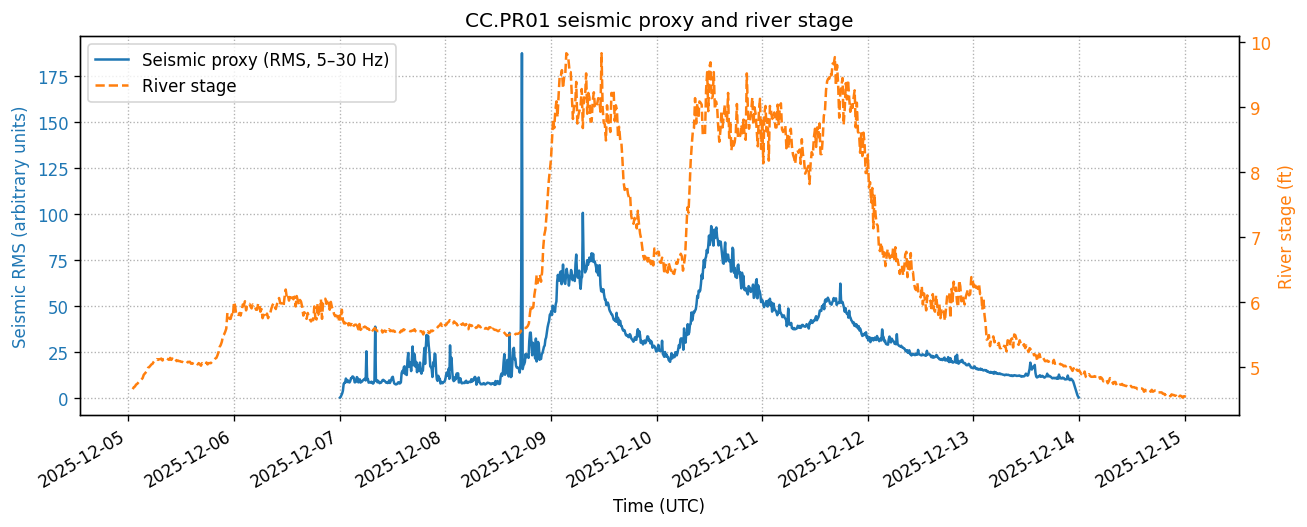

In [ ]:
import matplotlib.pyplot as plt

# pick one station and its paired USGS gauge
sta_key = list(proxies.keys())[0]
gid = PAIRINGS.get(sta_key)
if gid is None or gid not in gauges:
    raise KeyError(f"No gauge found for {sta_key}")

p = proxies[sta_key]
g = gauges[gid].copy()

fig, ax1 = plt.subplots(figsize=(11, 4.5))

# --- Seismic proxy (left axis) ---
ax1.plot(
    p.index,
    p.values,
    lw=1.5,
    color="tab:blue",
    label=f"Seismic proxy (RMS, {FMIN}-{FMAX} Hz)"
 )
ax1.set_ylabel("Seismic RMS (arbitrary units)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# --- River stage / gage height (right axis) ---
ax2 = ax1.twinx()
stage_col = "gage_height_ft" if "gage_height_ft" in g.columns else ("discharge_cfs" if "discharge_cfs" in g.columns else None)
if stage_col is None:
    raise KeyError(f"Gauge {gid} has no gage_height_ft or discharge_cfs columns")

ax2.plot(
    g.index,
    g[stage_col],
    lw=1.5,
    color="tab:orange",
    linestyle="-",
    label=f"USGS {gid} {stage_col}"
 )
ax2.set_ylabel(stage_col, color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

# --- Common formatting ---
ax1.set_title(f"{sta_key} seismic proxy and USGS {gid}")
ax1.set_xlabel("Time (UTC)")
ax1.grid(True, which="both", linestyle=":", linewidth=0.8)
plt.setp(ax1.get_xticklabels(), rotation=30, ha="right")

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.tight_layout()
plt.show()

## 4) Plotting and diagnostics

We provide:
- time-series overlay (proxy vs stage)
- hysteresis scatter plot (proxy vs stage)
- optional frequency-band sweep to test sensitivity


In [ ]:
from utils import plot_proxy_and_gauge, hysteresis_plot, band_sweep

NameError: name 'Stream' is not defined

### Run comparisons for your station↔gauge pairings


In [ ]:
# Run comparisons for station↔gage pairings derived from metadata
for sta_key, gid in PAIRINGS.items():
    if sta_key not in proxies:
        print(f"Skipping {sta_key} ↔ {gid} (missing seismic proxy)")
        continue
    if gid not in gauges:
        print(f"Skipping {sta_key} ↔ {gid} (missing gauge data)")
        continue

    title = f"{sta_key} proxy vs USGS {gid} (Dec 2025 window)"
    plot_proxy_and_gauge(proxies[sta_key], gauges[gid], title=title)
    hysteresis_plot(proxies[sta_key], gauges[gid], title=f"Hysteresis: {title}")

### Optional: frequency band sweep

If you suspect strong-motion sensors are missing the “classic” river band, sweep a few bands to see which one gives the cleanest storm-related signal.

Example bands:
- 2–8 Hz
- 5–15 Hz
- 10–30 Hz


In [ ]:
BANDS = [(2, 8), (5, 15), (10, 30)]

# Example: sweep for the first available station
sta_key = list(streams.keys())[0]
gid = PAIRINGS.get(sta_key)
if gid is None or gid not in gauges:
    raise KeyError(f"No gauge found for {sta_key}")

ev_times = None
if EXCLUDE_EARTHQUAKES:
    meta = STATION_META.get(sta_key, {})
    lat = meta.get("latitude")
    lon = meta.get("longitude")
    if lat is not None and lon is not None:
        ev_times = fetch_usgs_event_times(
            START, END, lat, lon,
            min_magnitude=EQ_MIN_MAG,
            maxradiuskm=EQ_MAXRADIUS_KM,
        )

band_sweep(
    streams[sta_key],
    gauges[gid],
    BANDS,
    station_name=sta_key,
    start=START,
    end=END,
    win_seconds=WIN_SECONDS,
    step_seconds=STEP_SECONDS,
    output=OUTPUT,
    event_times_utc=ev_times,
    event_buffer_s=EQ_BUFFER_SECONDS if EXCLUDE_EARTHQUAKES else 0,
 )

## 5) Next steps (toward sediment flux)

If you see a robust storm-correlated seismic band and **lag/hysteresis** relative to stage/discharge, the next upgrades are:

1. Replace RMS with **Welch PSD band power** per window.
2. Add a **coherence check** vs a reference station far from rivers (to suppress cultural noise).
3. Calibrate against any independent sediment proxy (geophones, turbidity/SSC, event yields).
4. Implement a **physics-based model/inversion** (Gimbert-style) if you have grain-size distributions and geometry.

If you want, paste the channel IDs printed above (or station metadata), and we can tighten channel selection (e.g., vertical-only vs RSS, exact HN? codes per site).
